In [17]:
import os
import sys

In [18]:
# Append python path - needed to import text_recognizer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [19]:
import text_recognizer.data

# Configure
emnist = text_recognizer.data.EMNIST()
print(emnist.__doc__)

EMNIST dataset of handwritten characters and digits.

    "The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19
    and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset."
    From https://www.nist.gov/itl/iad/image-group/emnist-dataset

    The data split we will use is
    EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
    


In [20]:
emnist.prepare_data()  # download, save to disk
emnist.setup()  # create torch.utils.data.Datasets, create train/val split


In [21]:
x, y = next(iter(emnist.train_dataloader()))

W


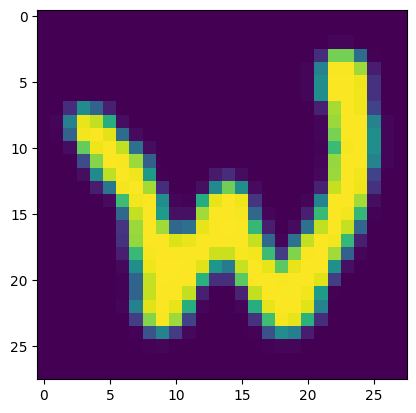

In [23]:
import random
import matplotlib.pyplot as plt


idx = random.randint(0, len(x) - 1)

print(emnist.mapping[y[idx]])
plt.imshow(x[idx].view(28,28))